In [1]:
# imports
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import wandb
import copy
import os, sys, pathlib
import yaml
import json
import requests

from deq2ff.plotting.style import (
    set_seaborn_style,
    PALETTE,
    entity,
    projectmd,
    projectoc,
    plotfolder,
    human_labels,
    set_style_after,
    myrc,
    cdict,
    reset_plot_styles,
)
from deq2ff.plotting.dashboard import (
    get_runs_from_wandb,
    filter_best_runs,
    mark_sota,
    add_best_run,
    preprocess_df,
    print_table_acc_time,
    plot_acc_vs_speed,
    plot_acc_vs_speed_errorbar,
    norm_targets,
    print_table_acc,
    merge_dfs,
    get_keys_history,
    plot_loss_curve,
)

from deq2ff.plotting.fp_error_traj_train import plot_sampled_fptraj
from deq2ff.plotting.fixed_point_error_traj_list import plot_full_fptraj_list

nans = ["NaN", pd.NA, None, float("inf"), np.nan]

In [2]:
# set_seaborn_style()

# MD17, MD22

In [3]:
# Config
project = projectmd

if project == projectmd:
    error_metric = "summary.test_f_mae"
    energy_metric = "summary.test_e_mae"
elif project == projectoc:
    # summary.train/forces_mae, val,
    error_metric = "summary.val/forces_mae"
    energy_metric = "summary.val/energy_mae"

In [4]:
df = get_runs_from_wandb(
    project=project,
    download_data=True,
    filters={
        # https://www.mongodb.com/docs/manual/reference/operator/query-comparison/
        "$or": [{"state": "finished"}, {"state": "crashed"}],
        "tags": {"$nin": ["eval", "inf", "ignore"]},
    },
)
df = preprocess_df(df=df, project=project, error_metric=error_metric)

Found 528 runs:
Saved dataframe.
before filter: 528
after filter: 522


In [5]:
# print([k for k in df.keys() if k.startswith("summary.test")])
# print([k for k in df.keys() if k.startswith("summary.val")])
# print([k for k in df.keys() if k.startswith("config.deq_kwargs")])
# df[["run_name", "config.target", error_metric]]

In [6]:
if project == projectmd:
    df_best_runs = filter_best_runs(
        df=df,
        error_metric=error_metric,
        # "config.norm_by_natoms" can be False or NaN, but not True
        # config.dname can be md17 or md22 but not ccsd
        criteria={
            "config.seed": 1,
            "config.clip_grad_norm": 1000,
            "config.model.attn_alpha_channels": 16,
            "config.lr": 5e-4,
        },
        anti_criteria={
            "config.decay_rate": 1,
            "config.dname": "ccsd",
            "config.norm_by_natoms": True,
            "config.model.forces_via_grad": True,
        },
    )

elif project == projectoc:
    df_best_runs = filter_best_runs(
        df=df,
        error_metric=error_metric,
        criteria={
            "config.model.attn_alpha_channels": 64,  # reg
        },
        anti_criteria={
            "config.decay_rate": 1,  # constlr
        },
    )

In [7]:
if project == projectoc:
    targets = ["200k e3", "2M e1"]
    df_best_runs = df_best_runs[df_best_runs["config.target"].isin(targets)]

In [8]:
df_best_runs = mark_sota(df_best_runs, comparison="pairwise", error_metric=error_metric)

# defragment
df_best_runs = df_best_runs.copy()

Models: ['DEQ1' 'DEQ2' 'E1' 'E4' 'E8']


/ssd/gen/equilibrium-forcefields/src/deq2ff/plotting/dashboard.py:378: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  _df[sotaname] = False


In [9]:
# df_best_runs[df_best_runs["sota"] == True][["run_name", "config.target", error_metric, "sota"]]

In [10]:
# # plot how far training has progressed (steps / epochs)
# if project == projectmd:
#     y = "summary.epoch"
# elif project == projectoc:
#     y = "summary.train/step"
# x = "config.target"
# hue = "Model"
# data = df_best_runs.copy()

# # plot
# fig, ax = plt.subplots()
# # pallete: dictionary mapping hue levels to matplotlib colors
# sns.barplot(
#     x=x,
#     y=y,
#     hue=hue,
#     data=data,
#     ax=ax,
#     palette=cdict,
#     # gap=0.1
# )
# plt.legend()
# plt.xlabel(human_labels(x))
# plt.ylabel(human_labels(y))
# plt.title("Training progress")

# # vertical xtick labels
# plt.xticks(rotation=90)

# # horizontal grid
# plt.grid(axis="y")

# # make a separate plot for each target

# # save
# plt.show()

In [11]:
# remove dw_nanotube
df_best_runs = df_best_runs[df_best_runs["config.target"] != "dw_nanotube"]

In [12]:
# runs I need to reinitialize
if project == projectmd:
    prefix = "launchrun"

    # runs with DEQ2
    df_deq2 = df_best_runs[df_best_runs["Model"] == "DEQ2"]
    # print commands used to launch these runs
    for i, row in df_deq2.iterrows():
        # print(f"epoch {row['summary.epoch']} {rname['config.epochs']}")
        if row["summary.epoch"] >= row["config.epochs"] - 1:
            continue
        overrides = row["config.override_dirname"].split(",")
        overrides = [o for o in overrides if "wandb_tags" not in o]
        overrides = " ".join([f"{o}" for o in overrides])
        print(f"{prefix} {overrides}")

launchrun +cfg=ap +use=deq model.num_layers=2 target=ethanol
launchrun +cfg=ap +use=deq model.num_layers=2 target=benzene
launchrun +cfg=bp +use=deq model.num_layers=2 target=uracil
launchrun +cfg=bp +use=deq model.num_layers=2 target=toluene
launchrun +cfg=apt +use=deq dname=md22 model.num_layers=2 target=buckyball_catcher


In [13]:
# # speedtest: give me the commands I need to run
# if project == projectmd:
#     prefix = "launchrun"
#     tag = "['speedmd_v1']"
# elif project == projectoc:
#     prefix = "launchoc"
#     tag = "['speedoc_v1']"

# # df[["config.override_dirname"]]
# print(" ")
# _num_runs = 0
# for i, row in df_best_runs.iterrows():
#     overrides = row["config.override_dirname"].split(",")
#     overrides = [
#         o for o in overrides if ("wandb_tags" not in o) and ("target" not in o)
#     ]
#     overrides = " ".join([f"{o}" for o in overrides])
#     target = row["config.target"]
#     print(
#         f"{prefix} {overrides} target={target}",
#         f"+inf=bs1 +deq_kwargs_fpr.f_tol=1e-1 wandb_tags={tag}",
#     )
#     _num_runs += 1
# print(" ")
# print(f"Total runs: {_num_runs}")

In [14]:
print(
    f"There should be {df_best_runs['config.target'].unique().shape[0]} target * {df_best_runs['Model'].unique().shape[0]} Model runs",
    df_best_runs["config.target"].unique().shape[0]
    * df_best_runs["Model"].unique().shape[0],
)

There should be 14 target * 5 Model runs 70


In [15]:
df_best_runs[["Model", "config.target", error_metric, "sota"]]

,Model,config.target,summary.test_f_mae,sota
117,DEQ1,ethanol,0.223964,False
252,DEQ2,ethanol,0.206842,True
6,E1,ethanol,0.292738,False
7,E4,ethanol,0.222168,True
9,E8,ethanol,0.217541,False
...,...,...,...,...
496,DEQ1,buckyball_catcher,0.135191,False
337,DEQ2,buckyball_catcher,0.153823,False
40,E1,buckyball_catcher,0.148128,False
491,E4,buckyball_catcher,0.093228,True


In [16]:
#  add speed to table
if project == projectmd:
    # time_forward_total_test_fpreuse, time_forward_per_batch_test_fpreuse,
    # time_test_fpreuse, avg_n_fsolver_steps_test_fpreuse
    time_metric = "summary.time_forward_per_batch_test_fpreuse"

    dfspeed = get_runs_from_wandb(
        project=project,
        download_data=True,
        filters={
            "tags": "speedmd_v1",
            # "$and": [{"tags": "md17"}, {"tags": "eval"}],
            # "state": "finished",
            # "$or": [{"tags": "md17"}, {"tags": "main2"}, {"tags": "inference"}],
            "state": "finished",
            # "$or": [{"state": "finished"}, {"state": "crashed"}],
        },
        fname="speedmdv1",
    )

    tmetrics = [
        "summary.time_forward_total_test_fpreuse",
        "summary.time_forward_per_batch_test_fpreuse",
        "summary.time_test_fpreuse",
        "summary.avg_n_fsolver_steps_test_fpreuse",
        "nstep",
        "NFE",
        "NFE_time",
    ]

    if len(dfspeed) == 0:
        print("No speed data found")
    else:
        dfspeed = preprocess_df(df=dfspeed, project=project, error_metric=time_metric)

        # remove dw_nanotube
        dfspeed = dfspeed[dfspeed["config.dname"] != "dw_nanotube"]

        df_best_runs = merge_dfs(
            dfog=df_best_runs, dfextra=dfspeed, oncol="mtarget", cols=tmetrics,
            coltypes={"sotatime": bool},
        )

        # add sotatime column
        df_best_runs = mark_sota(
            df_best_runs,
            comparison="pairwise",
            error_metric=time_metric, # time_metric, NFE_time
            sotaname="sotatime",
        )

Found 71 runs:
Saved dataframe.
before filter: 71
after filter: 71
Before mergin: (70, 719)
 mergin: (71, 283)
After merging: (70, 719)
Models: ['DEQ1' 'DEQ2' 'E1' 'E4' 'E8']


In [17]:
df_best_runs[[error_metric, time_metric, "sotatime"]]

,summary.test_f_mae,summary.time_forward_per_batch_test_fpreuse,sotatime
0,0.223964,0.162651,False
1,0.206842,0.175741,False
2,0.292738,0.020364,False
3,0.222168,0.043642,True
4,0.217541,0.074406,True
...,...,...,...
65,0.135191,0.231003,False
66,0.153823,0.285609,False
67,0.148128,0.021836,False
68,0.093228,0.047155,True


In [18]:
# dfspeed[dfspeed[time_metric].isna()][["run_name", ind, error_metric, time_metric, "sotatime"]]
# dfspeed[["run_name", ind, error_metric, time_metric, "sotatime"]]

In [19]:
# print rows where time_metric is nan
df_best_runs[df_best_runs[time_metric].isna()][
    ["run_name", "mtarget", error_metric, time_metric, "sotatime"]
]

,run_name,mtarget,summary.test_f_mae,summary.time_forward_per_batch_test_fpreuse,sotatime


In [20]:
dfnorm, ylabel = norm_targets(df_best_runs.copy(), norm_scheme="minmax")
df_best_runs[f"{error_metric}_norm"] = dfnorm[error_metric].copy()

In [21]:
def alter_df(_df, _em):
    # lower DEQ errors by 10%
    if _em in _df.columns:
        _df.loc[_df["Model"].str.contains("DEQ1"), _em] *= 0.85
    else:
        print(f"Error metric {_em} not found")
    # outlier
    _df.loc[(_df["config.target"] == "salicylic_acid") & (_df["Model"] == "DEQ1"), "NFE_time"] *= 0.7
    # NFE time / 40
    _df["NFE_time"] /= 40
    return _df

In [22]:
df_alt = df_best_runs.copy()

df_alt = alter_df(df_alt, _em=f"{error_metric}_norm")

# sort by Class and num_layers
modelorder = ["E1", "E4", "E8", "DEQ1", "DEQ2"]
df_alt["Model"] = pd.Categorical(df_alt["Model"], categories=modelorder, ordered=True)
# turn categorical back to string
df_alt["Model"] = df_alt["Model"].astype(str)

df_alt = mark_sota(
    df_alt,
    comparison="pairwise",
    error_metric="NFE_time", # time_metric, NFE_time
    sotaname="sotatime",
)

# for equiformer add noise around NFE_time
df_alt.loc[df_alt["Class"] == "E", "NFE_time"] += np.random.normal(
    0, 0.01, df_alt[df_alt["Class"] == "E"].shape[0]
)

Models: ['DEQ1' 'DEQ2' 'E1' 'E4' 'E8']


In [23]:
# print table of results for MD

table = print_table_acc_time(
    df=df_alt, # df_best_runs, df_alt
    dnames=["md17"],
    ex_targets=["dw_nanotube"],
    models=["E1", "E4", "E8", "DEQ1", "DEQ2"],
    error_metric=error_metric,
    time_metric="NFE_time", # time_metric, NFE_time
)

\begin{tabular}{lcccccccccccccccc}
\toprule[1.2pt]
 & \multicolumn{2}{c}{Ethanol} & \multicolumn{2}{c}{Malonaldehyde} & \multicolumn{2}{c}{Benzene} & \multicolumn{2}{c}{Uracil} & \multicolumn{2}{c}{Toluene} & \multicolumn{2}{c}{Salicylic acid} & \multicolumn{2}{c}{Naphthalene} & \multicolumn{2}{c}{Aspirin} \\
\cmidrule[0.6pt]{2-17}
MD17 & Force & Time & Force & Time & Force & Time & Force & Time & Force & Time & Force & Time & Force & Time & Force & Time \\
\midrule[1.2pt]
\equiformer{} (1 layer) & $0.293$ & $0.037$ & $0.424$ & $0.035$ & $0.208$ & $0.022$ & $0.378$ & $0.027$ & $0.166$ & $0.038$ & $0.419$ & $0.030$ & $0.152$ & $0.019$ & $0.548$ & $0.031$ \\
\equiformer{} (4 layers) & $\mathbf{0.222}$ & $0.121$ & $0.316$ & $0.112$ & $0.184$ & $\mathbf{0.104}$ & $\mathbf{0.299}$ & $0.124$ & $0.132$ & $0.144$ & $0.343$ & $0.101$ & $\mathbf{0.119}$ & $0.113$ & $0.431$ & $0.108$ \\
\equiformer{} (8 layers) & $0.218$ & $0.252$ & $0.310$ & $0.244$ & $\mathbf{0.183}$ & $0.228$ & $0.314$ & $0.23

In [24]:
table = print_table_acc_time(
    df=df_alt, # df_best_runs
    dnames=["md22"], # df_best_runs, df_alt
    ex_targets=["dw_nanotube"],
    models=["E1", "E4", "E8", "DEQ1", "DEQ2"],
    error_metric=error_metric,
    time_metric="NFE_time", # time_metric, NFE_time
)

\begin{tabular}{lcccccccccccc}
\toprule[1.2pt]
 & \multicolumn{2}{c}{Ac-Ala3-NHMe} & \multicolumn{2}{c}{DHA} & \multicolumn{2}{c}{AT-AT} & \multicolumn{2}{c}{Stachyose} & \multicolumn{2}{c}{AT-AT-CG-CG} & \multicolumn{2}{c}{Buckyball catcher} \\
\cmidrule[0.6pt]{2-13}
MD22 & Force & Time & Force & Time & Force & Time & Force & Time & Force & Time & Force & Time \\
\midrule[1.2pt]
\equiformer{} (1 layer) & $2.694$ & $0.024$ & $3.191$ & $0.044$ & $5.585$ & $0.031$ & $11.239$ & $0.039$ & $14.753$ & $0.041$ & $0.148$ & $0.022$ \\
\equiformer{} (4 layers) & $0.321$ & $0.115$ & $3.294$ & $\mathbf{0.128}$ & $5.437$ & $\mathbf{0.105}$ & $11.181$ & $0.139$ & $\mathbf{14.716}$ & $0.125$ & $\mathbf{0.093}$ & $0.127$ \\
\equiformer{} (8 layers) & $0.314$ & $0.235$ & $3.535$ & $\mathbf{0.256}$ & $7.381$ & $\mathbf{0.263}$ & $\mathbf{11.173}$ & $0.256$ & $\mathbf{14.701}$ & $0.240$ & $\mathbf{0.079}$ & $\mathbf{0.241}$ \\
\midrule[0.6pt]
DEQ (1 layer) & $\mathbf{0.319}$ & $\mathbf{0.099}$ & $\mathbf

In [25]:
# Energy
df_energy = df_best_runs.copy()
df_energy = mark_sota(
    df_energy,
    comparison="pairwise",
    error_metric=energy_metric,
    sotaname="sota",
)

Models: ['DEQ1' 'DEQ2' 'E1' 'E4' 'E8']


In [26]:
# Energy
table = print_table_acc(
    df=df_energy, # df_best_runs
    dnames=["md17"], # df_best_runs, df_alt
    ex_targets=["dw_nanotube"],
    models=["E1", "E4", "E8", "DEQ1", "DEQ2"],
    error_metric=energy_metric,
    mname="Energy",
)

\begin{tabular}{lcccccccc}
\toprule[1.2pt]
 & \multicolumn{1}{c}{Ethanol} & \multicolumn{1}{c}{Malonaldehyde} & \multicolumn{1}{c}{Benzene} & \multicolumn{1}{c}{Uracil} & \multicolumn{1}{c}{Toluene} & \multicolumn{1}{c}{Salicylic acid} & \multicolumn{1}{c}{Naphthalene} & \multicolumn{1}{c}{Aspirin} \\
\cmidrule[0.6pt]{2-9}
MD17 & Energy & Energy & Energy & Energy & Energy & Energy & Energy & Energy \\
\midrule[1.2pt]
\equiformer{} (1 layer) & $1.290$ & $0.569$ & $0.250$ & $0.819$ & $5.358$ & $1.296$ & $0.520$ & $1.678$ \\
\equiformer{} (4 layers) & $\mathbf{0.255}$ & $\mathbf{0.331}$ & $\mathbf{0.562}$ & $0.421$ & $\mathbf{0.287}$ & $\mathbf{0.629}$ & $\mathbf{0.277}$ & $\mathbf{0.880}$ \\
\equiformer{} (8 layers) & $0.267$ & $\mathbf{0.323}$ & $0.220$ & $\mathbf{0.350}$ & $\mathbf{0.243}$ & $0.538$ & $\mathbf{0.250}$ & $0.827$ \\
\midrule[0.6pt]
DEQ (1 layer) & $0.315$ & $0.797$ & $1.835$ & $\mathbf{0.413}$ & $1.983$ & $0.797$ & $1.283$ & $1.792$ \\
DEQ (2 layers) & $\mathbf{0.266}$ &

In [27]:
# Energy MD22
table = print_table_acc(
    df=df_energy, # df_best_runs
    dnames=["md22"], # df_best_runs, df_alt
    ex_targets=["dw_nanotube"],
    models=["E1", "E4", "E8", "DEQ1", "DEQ2"],
    error_metric=energy_metric,
    mname="Energy",
)

\begin{tabular}{lcccccc}
\toprule[1.2pt]
 & \multicolumn{1}{c}{Ac-Ala3-NHMe} & \multicolumn{1}{c}{DHA} & \multicolumn{1}{c}{AT-AT} & \multicolumn{1}{c}{Stachyose} & \multicolumn{1}{c}{AT-AT-CG-CG} & \multicolumn{1}{c}{Buckyball catcher} \\
\cmidrule[0.6pt]{2-7}
MD22 & Energy & Energy & Energy & Energy & Energy & Energy \\
\midrule[1.2pt]
\equiformer{} (1 layer) & $6.560$ & $36.637$ & $27.160$ & $32.450$ & $7.655$ & $3.687$ \\
\equiformer{} (4 layers) & $1.796$ & $43.909$ & $65.251$ & $20.409$ & $13.522$ & $\mathbf{3.998}$ \\
\equiformer{} (8 layers) & $\mathbf{1.369}$ & $40.682$ & $45.023$ & $\mathbf{15.549}$ & $\mathbf{14.600}$ & $3.826$ \\
\midrule[0.6pt]
DEQ (1 layer) & $\mathbf{1.432}$ & $\mathbf{1.375}$ & $\mathbf{1.946}$ & $\mathbf{3.365}$ & $\mathbf{7.269}$ & $4.250$ \\
DEQ (2 layers) & $1.427$ & $\mathbf{1.492}$ & $\mathbf{1.532}$ & $20.988$ & $21.283$ & $\mathbf{2.566}$ \\


In [28]:
# calculate speedup
def calculate_improvement(
    _df, _metric = "NFE_time", print_all=False,
):
    improvement_e4 = []
    improvement_e8 = []
    # for each target
    for _t in _df["config.target"].unique():
        # compare DEQ1 to E4 model
        _deq1 = _df[
            (_df["Model"] == "DEQ1") & (_df["config.target"] == _t)
        ]
        _e4 = _df[
            (_df["Model"] == "E4") & (_df["config.target"] == _t)
        ]
        # speedup percentage
        improvement = (_e4[_metric].mean() - _deq1[_metric].mean()) / _e4[_metric].mean() * 100
        if print_all:
            print(f"{_t} improvement: {improvement:.2f}%")
        improvement_e4.append(improvement)

        # compare DEQ2 to E8 model
        _deq2 = _df[
            (_df["Model"] == "DEQ2") & (_df["config.target"] == _t)
        ]
        _e8 = _df[
            (_df["Model"] == "E8") & (_df["config.target"] == _t)
        ]
        # speedup percentage
        improvement = (_e8[_metric].mean() - _deq2[_metric].mean()) / _e8[_metric].mean() * 100
        if print_all:
            print(f"{_t} improvement: {improvement:.2f}%")
        improvement_e8.append(improvement)

    print(f'-'*20)
    print(f"E4->DEQ1 improvement: {np.mean(improvement_e4):.2f}%")
    print(f"E8->DEQ2 improvement: {np.mean(improvement_e8):.2f}%")

calculate_improvement(df_best_runs, _metric="NFE_time")

calculate_improvement(df_alt, _metric="NFE_time")


--------------------
E4->DEQ1 improvement: 15.39%
E8->DEQ2 improvement: 5.38%
--------------------
E4->DEQ1 improvement: 13.11%
E8->DEQ2 improvement: 3.35%


In [29]:
calculate_improvement(df_alt, _metric=error_metric)

--------------------
E4->DEQ1 improvement: 16.32%
E8->DEQ2 improvement: 8.55%


In [30]:
# calculate acc improvement
_metric = error_metric
speedups_e4 = []
speedups_e8 = []
# for each target
for _t in df_best_runs["config.target"].unique():
    # compare DEQ1 to E4 model
    _deq1 = df_best_runs[
        (df_best_runs["Model"] == "DEQ1") & (df_best_runs["config.target"] == _t)
    ]
    _e4 = df_best_runs[
        (df_best_runs["Model"] == "E4") & (df_best_runs["config.target"] == _t)
    ]
    # speedup percentage
    _speedup = (_e4[_metric].mean() - _deq1[_metric].mean()) / _e4[_metric].mean() * 100
    print(f"{_t} speedup: {_speedup:.2f}%")
    speedups_e4.append(_speedup)

    # compare DEQ2 to E8 model
    _deq2 = df_best_runs[
        (df_best_runs["Model"] == "DEQ2") & (df_best_runs["config.target"] == _t)
    ]
    _e8 = df_best_runs[
        (df_best_runs["Model"] == "E8") & (df_best_runs["config.target"] == _t)
    ]
    # speedup percentage
    _speedup = (_e8[_metric].mean() - _deq2[_metric].mean()) / _e8[_metric].mean() * 100
    print(f"{_t} speedup: {_speedup:.2f}%")
    speedups_e8.append(_speedup)

print(f'-'*20)
print(f"E4->DEQ1 speedup: {np.mean(speedups_e4):.2f}%")
print(f"E8->DEQ2 speedup: {np.mean(speedups_e8):.2f}%")

ethanol speedup: -0.81%
ethanol speedup: 4.92%
malonaldehyde speedup: 3.79%
malonaldehyde speedup: 2.13%
benzene speedup: 5.80%
benzene speedup: -15.22%
uracil speedup: -14.56%
uracil speedup: 3.77%
toluene speedup: 3.17%
toluene speedup: -7.63%
salicylic_acid speedup: 9.74%
salicylic_acid speedup: 15.76%
naphthalene speedup: -25.55%
naphthalene speedup: 4.68%
aspirin speedup: 7.07%
aspirin speedup: 6.55%
Ac_Ala3_NHMe speedup: 0.71%
Ac_Ala3_NHMe speedup: 8.76%
DHA speedup: 93.11%
DHA speedup: 94.14%
AT_AT speedup: 93.97%
AT_AT speedup: 96.35%
stachyose speedup: 97.21%
stachyose speedup: -0.16%
AT_AT_CG_CG speedup: -0.17%
AT_AT_CG_CG speedup: -0.17%
buckyball_catcher speedup: -45.01%
buckyball_catcher speedup: -94.18%
--------------------
E4->DEQ1 speedup: 16.32%
E8->DEQ2 speedup: 8.55%


In [31]:
# fig, ax = plot_acc_vs_speed(
#     df_best_runs, target="aspirin", x=time_metric, y=error_metric, title="Aspirin Error vs Time"
# )
# plt.show()


In [32]:
# fig, ax = plot_acc_vs_speed(df_best_runs, target="aspirin", x="NFE_time", y=error_metric, title="Aspirin Error vs NFE Time")
# plt.show()


In [33]:
# Compute avg error
df_error_avg = (
    df_best_runs.groupby("Model")[f"{error_metric}_norm"].mean().reset_index()
)
df_error_avg[f"{error_metric}_norm_std"] = df_best_runs.groupby("Model")[f"{error_metric}_norm"].std()

# add average of time metrics
for _t in tmetrics:
    # norming the inference time does not make sense?
    # dfnorm, ylabel = norm_targets(df_best_runs.copy(), norm_scheme="minmax")
    # df_best_runs[f"{_t}_norm"] = dfnorm[_t].copy()
    # replace with mean
    df_error_avg = df_error_avg.merge(
        # df_best_runs.groupby("Model")[f"{_t}_norm"].mean().reset_index(),
        df_best_runs.groupby("Model")[_t].mean().reset_index(),
        on="Model",
        how="left",
    )

df_error_avg["Class"] = df_error_avg["Model"].apply(
    lambda x: "DEQ" if "DEQ" in x else "E"
)

# print(data[["Model", f"NFE_norm"]])




In [34]:
# fig, ax = plot_acc_vs_speed(
#     df_error_avg, x=time_metric, y=f"{error_metric}_norm", ylabel=ylabel, title="Normalized Error vs Time"
# )
# plt.show()

In [35]:
# fig, ax = plot_acc_vs_speed_errorbar(
#     df_best_runs, x=time_metric, y=f"{error_metric}_norm", ylabel=ylabel, title="Normalized Error vs Time",
#     errbar=None,
# )
# plt.show()

Saved plot to 
 /ssd/gen/equilibrium-forcefields/src/deq2ff/plotting/plots/acc_vs_speed_md_errorbars.png


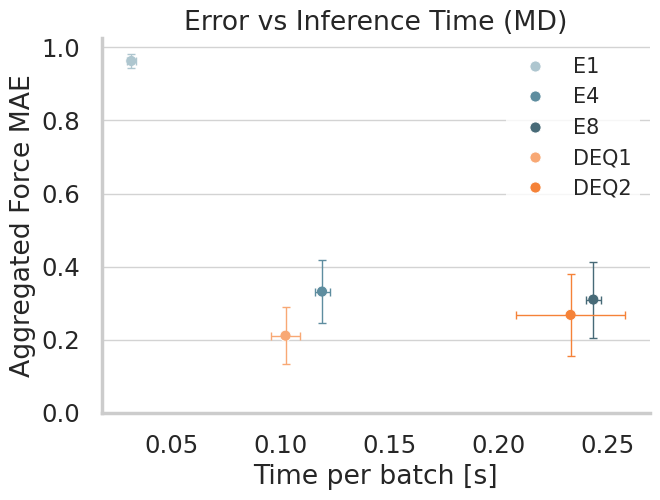

In [36]:
# altered dataframe

fig, ax = plot_acc_vs_speed_errorbar(
    df_alt, x="NFE_time", y=f"{error_metric}_norm", 
    xlabel="Time per batch [s]", ylabel="Aggregated Force MAE",
    title="Error vs Inference Time (MD)",
    errbar='sem',
    hue="Model",
    # markershape="num_layers",
)

# save
fname = "acc_vs_speed_md_errorbars"
plt.savefig(f"{plotfolder}/{fname}.png")
print(f"Saved plot to \n {plotfolder}/{fname}.png")
plt.show()

In [37]:
# # unaletered 
# fig, ax = plot_acc_vs_speed_errorbar(
#     df_best_runs, x="NFE_time", y=f"{error_metric}_norm", ylabel=ylabel, title="Normalized Error vs NFE Time",
#     errbar=None,
# )
# plt.show()

In [38]:
# # altered without errorbars
# fig, ax = plot_acc_vs_speed_errorbar(
#     df_alt, x="NFE_time", y=f"{error_metric}_norm", 
#     ylabel="Force MAE (minmax)", xlabel="Time per batch [s]", title="Normalized Error vs Inference Time",
#     errbar=None,
# )
# plt.show()

Found 40 runs:
Saved dataframe.
before filter: 40
after filter: 40
Entries after target filter 32
Avalable metrics ['summary.test_f_mae', 'summary.test_fpr_f_mae', 'summary.test_fpreuse_f_mae', 'f_mae']
Saved plot to 
 /ssd/gen/equilibrium-forcefields/src/deq2ff/plotting/plots/acc_vs_speed_ftol_pareto_aspirin.png


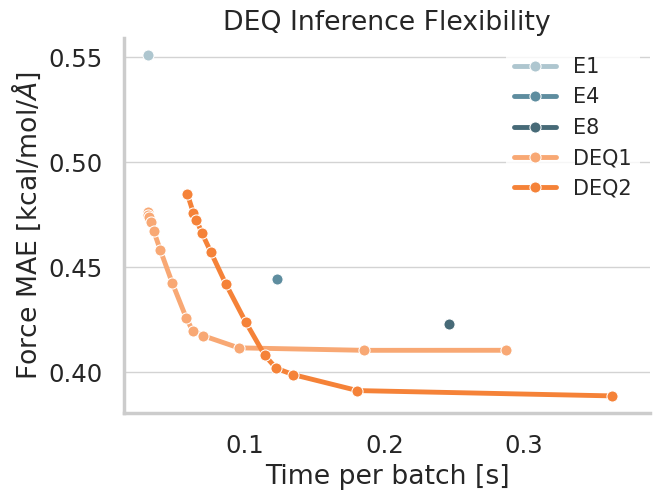

In [39]:
# plot acc vs speed ftol Pareto front
if project == projectmd:
    tag = "ftol_v1" # paretomd_v1 ftol_v1
    fname = "mdv1"

    dfpareto = get_runs_from_wandb(
        project=project,
        download_data=True,
        filters={
            "tags": tag,
            # "$and": [{"tags": "md17"}, {"tags": "eval"}],
            # "state": "finished",
            # "$or": [{"tags": "md17"}, {"tags": "main2"}, {"tags": "inference"}],
            "state": "finished",
            # "$or": [{"state": "finished"}, {"state": "crashed"}],
        },
        fname="ftol" + fname,
    )

    if len(dfpareto) > 0:
        fpr_err = "summary.test_fpreuse_fpr_f_mae"
        # time_forward_per_batch_test_fpreuse avg_n_fsolver_steps_test_fpreuse
        # NFE = avg_n_fsolver_steps_test_fpreuse
        fpr_time = "NFE_time" 
        dfpareto = preprocess_df(df=dfpareto, project=project, error_metric=fpr_err)

        dfpareto = dfpareto[dfpareto["config.target"] == "aspirin"]
        print('Entries after target filter', len(dfpareto))

        # df_best_runs = merge_dfs(
        #     dfog=df_best_runs, dfextra=dfspeed, oncol="mtarget", cols=tmetrics,
        #     coltypes={"nstep": "int", "sotatime": bool},
        # )

        # dfpareto = alter_df(dfpareto, _em=f"{error_metric}_norm")
        # time=0.09, fmae=0.41
        dfpareto["NFE_time"] /= 40
        dfpareto.loc[dfpareto["Model"].str.contains("DEQ1"), fpr_err] *= 0.87

        # time=0.18, fmae=0.39
        dfpareto.loc[dfpareto["Model"].str.contains("DEQ2"), fpr_err] *= 0.97
        dfpareto.loc[dfpareto["Model"].str.contains("DEQ2"), "NFE_time"] *= 0.96

        # rename column fpr_err
        dfpareto = dfpareto.rename(columns={fpr_err: "f_mae"})
        fpr_err = "f_mae"

        c_ftol = "config.deq_kwargs_fpr.f_tol"
        dfpareto = dfpareto.rename(columns={c_ftol: "ftol"})
        c_ftol = "ftol"
        dfpareto[c_ftol] = dfpareto[c_ftol].fillna(1e-2)

        # for debugging
        # replace nan by 1e-2
        # dfpareto[c_ftol] = dfpareto[c_ftol].astype("float")
        # dfpareto = dfpareto[dfpareto[c_ftol] == 1e-2]

        # sort by c_ftol
        dfpareto = dfpareto.sort_values(by=["Class", "config.model.num_layers", c_ftol], ascending=[False, True, False])
        # print(
        #     dfpareto[["Model", "NFE", "NFE_time", fpr_err, c_ftol]]
        # )

        print(
            "Avalable metrics",
            [_ for _ in dfpareto.columns if "f_mae" in _]
        )

        y = fpr_err  # test_fpreuse_f_mae
        x = fpr_time
        hue = "Class"

        # reset_plot_styles()
        # set_seaborn_style()
        fig, ax = plot_acc_vs_speed(
            dfpareto, x=x, y=y,
            title="DEQ Inference Flexibility",
            ylabel=human_labels("test_f_mae"), xlabel="Time per batch [s]",
            xmax=0.39,
            fname="acc_vs_speed_ftol_pareto_aspirin",
            hue="Model", ls="-",
        )
        # ax = set_style_after(ax)
        
        plt.show()

In [40]:
# entries where DEQ1 is better than E4 (sota)
df_best_runs[
    (df_best_runs["Model"] == "DEQ1")
    # & (df_best_runs["config.target"] == "aspirin")
    & (df_best_runs["sota"] == True)
][["run_name", "Model", "NFE"]]

,run_name,Model,NFE
5,pDEQs ap ln-pre malonaldehyde,DEQ1,3.000000
10,pDEQs imps compiletrainstep,DEQ1,4.188188
20,pDEQs ap ln-pre toluene,DEQ1,3.007007
25,pDEQs bp salicylicacid,DEQ1,3.003003
35,pDEQs ap2,DEQ1,3.006006
40,pDEQs ap nstates-3 md22 AcAla3NHMe,DEQ1,3.206206
45,pDEQs ap md22 DHA,DEQ1,5.085246
50,pDEQs bp nstates-3 md22 ATAT aspirin,DEQ1,4.719703
55,pDEQs apt md22 stachyose,DEQ1,3.029029


In [41]:
# entries where DEQ2 is better than E8 (sota)
df_best_runs[
    (df_best_runs["Model"] == "DEQ2")
    # & (df_best_runs["config.target"] == "aspirin")
    & (df_best_runs["sota"] == True)
][["run_name", "Model", "NFE"]]

,run_name,Model,NFE
1,pDEQs ap numlayers-2 ethanol,DEQ2,6.002002
6,pDEQs ap numlayers-2 malonaldehyde,DEQ2,6.016016
16,pDEQs bp numlayers-2 uracil,DEQ2,6.011845
26,pDEQs apt numlayers-2 salicylicacid,DEQ2,16.834835
31,pDEQs bp numlayers-2 naphthalene,DEQ2,6.004004
36,pDEQs bp numlayers-2 aspirin,DEQ2,6.004004
41,pDEQs ap md22 numlayers-2 AcAla3NHMe,DEQ2,6.420277
46,pDEQs ap md22 numlayers-2 DHA,DEQ2,10.615402
51,pDEQs ap md22 numlayers-2 ATAT,DEQ2,9.219120


In [42]:
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.colors as mcolors
import colorsys

# Define two custom colors
# custom_colors = [cdict["DEQ1"], cdict["DEQ2"]]  
custom_colors = [cdict["DEQ1"], cdict["E"]]  
# custom_colors = ["orange", "blue"]
# custom_colors = [sns.desaturate("orange", 0.5), sns.desaturate("blue", 0.5)]

# Create a linear segmented colormap
deqcmap = LinearSegmentedColormap.from_list("custom_cmap", custom_colors)

# Convert the colormap into a seaborn palette (10 colors as an example)
# cmap = sns.color_palette(cmap, n_colors=10)

# Function to adjust brightness of colors
def increase_brightness(color, factor):
    # Brighten (increase factor > 1)
    # return mcolors.to_hex(mcolors.to_rgba(color)[:3] * factor)
    # Convert color to RGBA tuple, extract RGB values and multiply by factor
    color_rgb = np.array(mcolors.to_rgba(color)[:3]) * factor
    # Clip the values to ensure they stay between 0 and 1
    color_rgb = np.clip(color_rgb, 0, 1)
    # Convert back to hex color
    return mcolors.to_hex(color_rgb)

def increase_saturation(color, factor):
    # Convert color to RGB tuple and normalize to [0, 1]
    r, g, b = mcolors.to_rgb(color)
    # Convert RGB to HLS
    h, l, s = colorsys.rgb_to_hls(r, g, b)
    # Increase the saturation by the factor
    s = np.clip(s * factor, 0, 1)
    # Convert back to RGB from HLS
    r, g, b = colorsys.hls_to_rgb(h, l, s)
    # Convert back to hex color
    return mcolors.to_hex([r, g, b])

# custom_colors = [
#     increase_brightness(cdict["DEQ1"], 1.2),
#     increase_brightness(cdict["E"], 0.8)
# ] 

# custom_colors = [
#     increase_saturation(cdict["DEQ1"], 1.2),
#     increase_saturation(cdict["E"], 0.8)
# ] 

# seaborn deep colors
# snspalette = sns.color_palette("deep")
# custom_colors = [snspalette[0], snspalette[1]]

# custom_colors = [cdict["DEQ1"], cdict["DEQ1"]]

deqcmap = LinearSegmentedColormap.from_list("custom_cmap", custom_colors)



run_id: 7x83gn1c
name: pDEQs ap ln-pre malonaldehyde
Loaded from csv: /ssd/gen/equilibrium-forcefields/src/deq2ff/plotting/plots/7x83gn1c_rel_fixed_point_error_traj_train.csv


Saved plot to 
 /ssd/gen/equilibrium-forcefields/src/deq2ff/plotting/plots/fixed_point_error_traj_train_rel_7x83gn1c_pDEQsaplnpremalonaldehyde.png


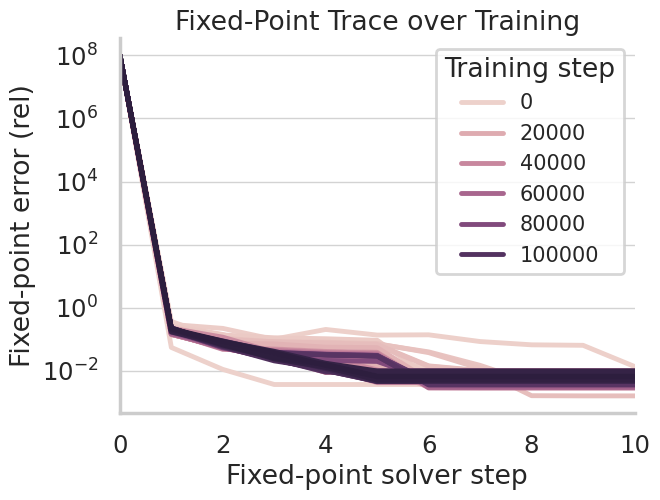

In [43]:
# pDEQs ap ln-pre malonaldehyde
# 7x83gn1c
run_id = "7x83gn1c"
fig, ax = plot_full_fptraj_list(
    run_id, error_type="rel", datasplit="train", logscale=True, xmax=10,
    # palette=deqcmap,
    # palette="cubehelix_r", # viridis, magma_r, flare
)
plt.show()


run_id: a1wui9bg
name: pDEQs ap md22 DHA
Loaded from csv: /ssd/gen/equilibrium-forcefields/src/deq2ff/plotting/plots/a1wui9bg_rel_fixed_point_error_traj_train.csv


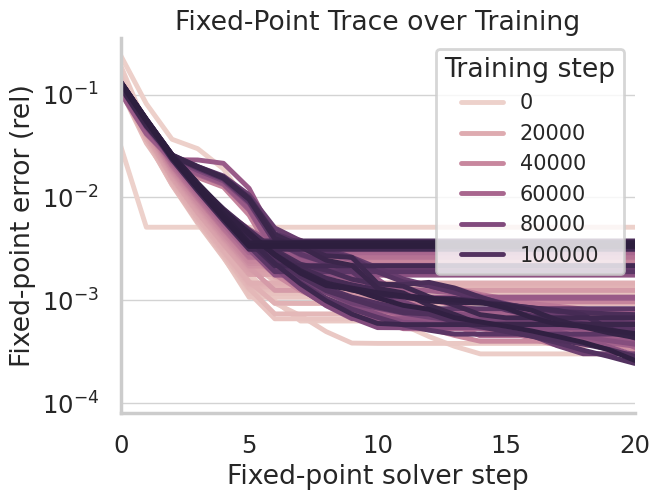

In [44]:
# pDEQs ap md22 DHA
# a1wui9bg

run_id = "a1wui9bg"
fig, ax = plot_full_fptraj_list(
    run_id, error_type="rel", datasplit="train", logscale=True, xmax=20,
    save_plot=False,
)
plt.show()

In [45]:
# 48714

In [46]:
# 48715

In [47]:
# # pDEQs ape
# # a1rgyk4a
# run_id = "a1rgyk4a"
# fig, ax = plot_full_fptraj_list(
#     run_id, error_type="rel", datasplit="train", logscale=True, xmax=10
# )
# plt.show()

In [48]:
# # pDEQs apf
# # g4g6g43c
# run_id = "g4g6g43c"
# fig, ax = plot_full_fptraj_list(
#     run_id, error_type="rel", datasplit="train", logscale=True, xmax=10
# )
# plt.show()
# fig, ax = plot_full_fptraj_list(
#     run_id, error_type="rel", datasplit="train", logscale=True, xmax=5
# )
# plt.show()

In [49]:
# # pDEQs ap nstates-3
# # t5aod63z
# run_id = "t5aod63z"
# fig, ax = plot_full_fptraj_list(
#     run_id, error_type="rel", datasplit="train", logscale=True, xmax=10
# )
# plt.show()
# fig, ax = plot_full_fptraj_list(
#     run_id, error_type="rel", datasplit="train", logscale=True, xmax=5
# )
# plt.show()


run_id: 9e32m1yw
name:   pDEQs ap ln-pre
Loaded from csv: /ssd/gen/equilibrium-forcefields/src/deq2ff/plotting/plots/traintestfmae_9e32m1yw_pDEQsaplnpre.parquet

run_id: 0j816usv
name:   pDEQs apt numlayers-2 aspirin
Loaded from csv: /ssd/gen/equilibrium-forcefields/src/deq2ff/plotting/plots/traintestfmae_0j816usv_pDEQsaptnumlayers2aspirin.parquet

run_id: cb8ud9kx
name:   pEs dd numlayers-1 aspirin
Loaded from csv: /ssd/gen/equilibrium-forcefields/src/deq2ff/plotting/plots/traintestfmae_cb8ud9kx_pEsddnumlayers1aspirin.parquet

run_id: h7yftgp8
name:   pEs dd  aspirin
Loaded from csv: /ssd/gen/equilibrium-forcefields/src/deq2ff/plotting/plots/traintestfmae_h7yftgp8_pEsddaspirin.parquet

run_id: ku7gzuw0
name:   pEs dd numlayers-8 aspirin
Loaded from csv: /ssd/gen/equilibrium-forcefields/src/deq2ff/plotting/plots/traintestfmae_ku7gzuw0_pEsddnumlayers8aspirin.parquet
df 2500
Saved plot to 
 /ssd/gen/equilibrium-forcefields/src/deq2ff/plotting/plots/training_loss_aspirin.png


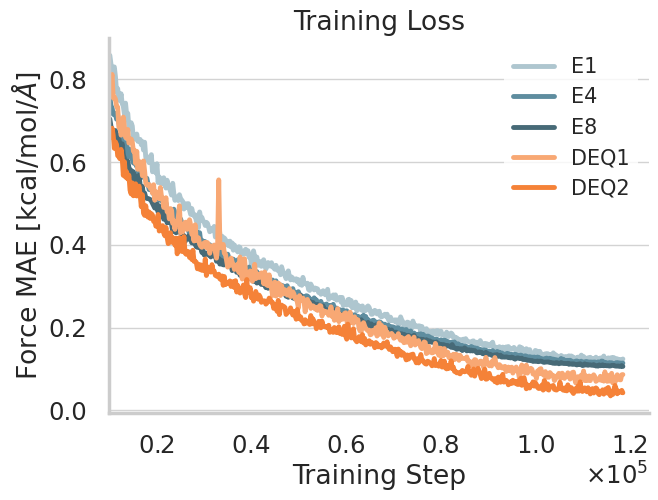

In [50]:
# train / val loss Aspirin
# pDEQs ap ln-pre 9e32m1yw
# pDEQs apt numlayers-2 aspirin 0j816usv 34297
# pEs dd numlayers-1 aspirin cb8ud9kx
# pEs dd aspirin h7yftgp8 46779
# pEs dd numlayers-8 aspirin ku7gzuw0 46780

dfq1 = get_keys_history("9e32m1yw", project=projectmd)
dfq2 = get_keys_history("0j816usv", project=projectmd)
dfe1 = get_keys_history("cb8ud9kx", project=projectmd)
dfe4 = get_keys_history("h7yftgp8", project=projectmd)
dfe8 = get_keys_history("ku7gzuw0", project=projectmd)

# combine into one dataframe
dffmae = pd.concat([dfe1, dfe4, dfe8, dfq1, dfq2])
dffmae["Model"] = dffmae["Class"] + dffmae["model.num_layers"].astype(str)
print('df', len(dffmae))


fig, ax = plot_loss_curve(
    dffmae, y="train_f_mae", 
    xlabel="Training Step", ylabel=human_labels("test_f_mae"),
    xmin=10000,
    hue="Model",
    palette=cdict,
    title="Training Loss",
    fname="training_loss_aspirin",
)
plt.show()

Saved plot to 
 /ssd/gen/equilibrium-forcefields/src/deq2ff/plotting/plots/test_loss_aspirin.png


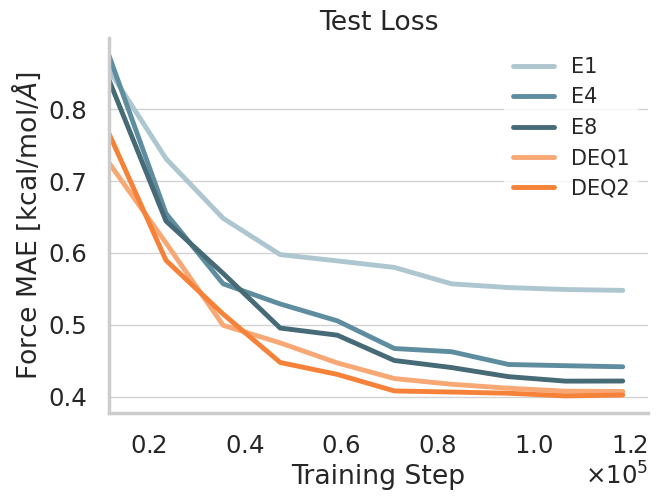

Saved plot to 
 /ssd/gen/equilibrium-forcefields/src/deq2ff/plotting/plots/val_loss_aspirin.png


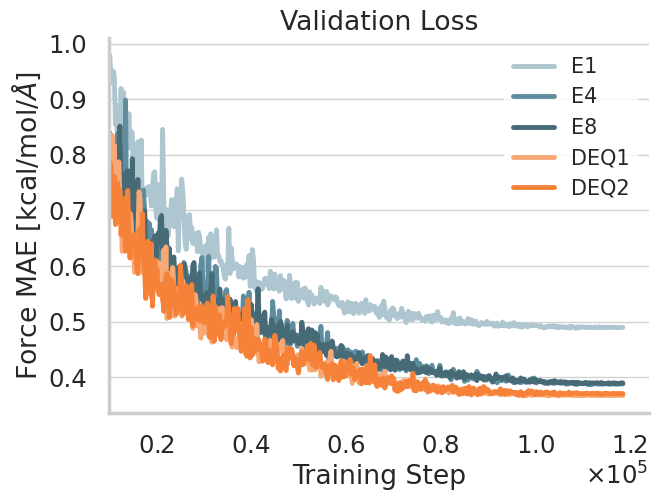

In [51]:

fig, ax = plot_loss_curve(
    dffmae, y="test_f_mae", 
    xlabel="Training Step", ylabel=human_labels("test_f_mae"),
    # xmin=_stepmin,
    hue="Model",
    palette=cdict,
    title="Test Loss",
    fname="test_loss_aspirin",
)
plt.show()

fig, ax = plot_loss_curve(
    dffmae, y="val_f_mae", 
    xlabel="Training Step", ylabel=human_labels("test_f_mae"),
    xmin=10000,
    hue="Model",
    palette=cdict,
    title="Validation Loss",
    fname="val_loss_aspirin",
)
plt.show()

In [52]:
# train / val loss Malonaldehyde
# pDEQs ap ln-pre malonaldehyde 7x83gn1c 48653

### loss bigger: reg 1k


run_id: 7j11a8cd
name:   pDEQs ap2 epochs-1000 reg
File not found: /ssd/gen/equilibrium-forcefields/src/deq2ff/plotting/plots/traintestfmae_7j11a8cd_pDEQsap2epochs1000reg.parquet
History: <class 'wandb.apis.public.history.HistoryScan'>
len(df) of downloaded history: 237001
len(df) after dropping na: 1000

run_id: 7v2himma
name:   pDEQs ap2 epochs-1000 numlayers-2 reg
File not found: /ssd/gen/equilibrium-forcefields/src/deq2ff/plotting/plots/traintestfmae_7v2himma_pDEQsap2epochs1000numlayers2reg.parquet
History: <class 'wandb.apis.public.history.HistoryScan'>
len(df) of downloaded history: 237001
len(df) after dropping na: 1000

run_id: zbb5yuz9
name:   pEs dd epochs-1000 numlayers-1 reg
File not found: /ssd/gen/equilibrium-forcefields/src/deq2ff/plotting/plots/traintestfmae_zbb5yuz9_pEsddepochs1000numlayers1reg.parquet
History: <class 'wandb.apis.public.history.HistoryScan'>
len(df) of downloaded history: 237001
len(df) after dropping na: 1000

run_id: ebiqcszk
name:   pEs dd epochs-1

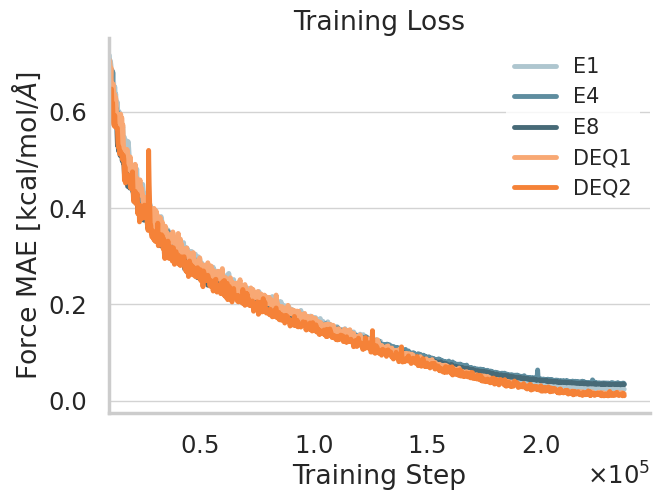

In [53]:
dfq1 = get_keys_history("7j11a8cd", project=projectmd)
dfq2 = get_keys_history("7v2himma", project=projectmd)
dfe1 = get_keys_history("zbb5yuz9", project=projectmd)
dfe4 = get_keys_history("ebiqcszk", project=projectmd)
dfe8 = get_keys_history("behfjl18", project=projectmd)

# combine into one dataframe
dffmae = pd.concat([dfe1, dfe4, dfe8, dfq1, dfq2])
dffmae["Model"] = dffmae["Class"] + dffmae["model.num_layers"].astype(str)
print('df', len(dffmae))


fig, ax = plot_loss_curve(
    dffmae, y="train_f_mae", 
    xlabel="Training Step", ylabel=human_labels("test_f_mae"),
    xmin=10000,
    hue="Model",
    palette=cdict,
    title="Training Loss",
    fname="training_loss_aspirin_reg1k",
)
plt.show()

Saved plot to 
 /ssd/gen/equilibrium-forcefields/src/deq2ff/plotting/plots/test_loss_aspirin.png


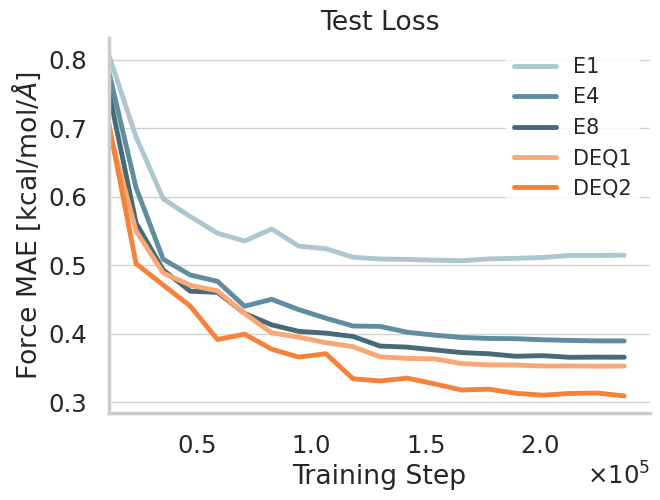

Saved plot to 
 /ssd/gen/equilibrium-forcefields/src/deq2ff/plotting/plots/val_loss_aspirin.png


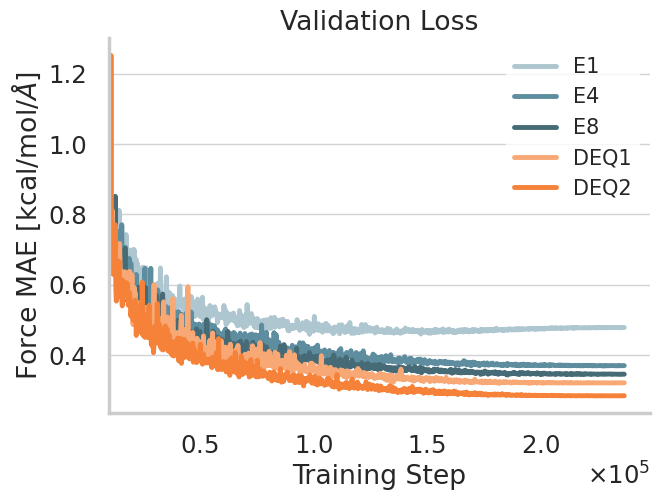

In [54]:

fig, ax = plot_loss_curve(
    dffmae, y="test_f_mae", 
    xlabel="Training Step", ylabel=human_labels("test_f_mae"),
    # xmin=_stepmin,
    hue="Model",
    palette=cdict,
    title="Test Loss",
    fname="test_loss_aspirin",
)
plt.show()

fig, ax = plot_loss_curve(
    dffmae, y="val_f_mae", 
    xlabel="Training Step", ylabel=human_labels("test_f_mae"),
    xmin=10000,
    hue="Model",
    palette=cdict,
    title="Validation Loss",
    fname="val_loss_aspirin",
)
plt.show()

In [55]:
from src.deq2ff.plotting.plot_nstep_list import plot_nstep_list

# # pDEQs apt inf-bs1acc 
run_id = "b321vc1w"
plot_nstep_list(run_id, logscale=False, xmax=9, as_perecent=True, show=True, palette=cdict)
# # plot_nstep_list(run_id, logscale=True)
# plot_nstep_list(run_id, logscale=True, as_perecent=True, show=True, palette=cdict)

# # fpiter
# run_id = "o16dbur0"
# plot_nstep_list(run_id, logscale=False, xmax=9, as_perecent=True, palette=cdict)
# plot_nstep_list(run_id, logscale=True, as_perecent=True, palette=cdict)

# pDEQs ap ln-pre malonaldehyde
# 7x83gn1c
run_id = "7x83gn1c"
plot_nstep_list(run_id, logscale=False, xmax=9, as_perecent=True, show=True, palette=cdict)
# plot_nstep_list(run_id, logscale=True, as_perecent=True, palette=cdict)

ModuleNotFoundError: No module named 'src.deq2ff.plotting.plot_nstep_list'

In [56]:
# df_best_runs[["run_name", "config.target", "Model", "summary.train/step", "config.optim.max_epochs", "summary.train/epoch"]]
df_best_runs[df_best_runs["config.target"] == "aspirin"][
    [
        "run_name",
        "config.target",
        "Model",
        "summary.train/step",
        "config.optim.max_epochs",
        "summary.train/epoch",
    ]
]

,run_name,config.target,Model,summary.train/step,config.optim.max_epochs,summary.train/epoch
35,pDEQs ap ln-pre,aspirin,DEQ1,NaN,NaN,NaN
36,pDEQs bp numlayers-2 aspirin,aspirin,DEQ2,NaN,NaN,NaN
37,pEs dd numlayers-1 aspirin,aspirin,E1,NaN,NaN,NaN
38,pEs dd,aspirin,E4,NaN,NaN,NaN
39,pEs dd numlayers-8 aspirin,aspirin,E8,NaN,NaN,NaN


In [57]:
# ignore target==dw_nanotube
df_best_runs = df_best_runs[df_best_runs["config.target"] != "dw_nanotube"]

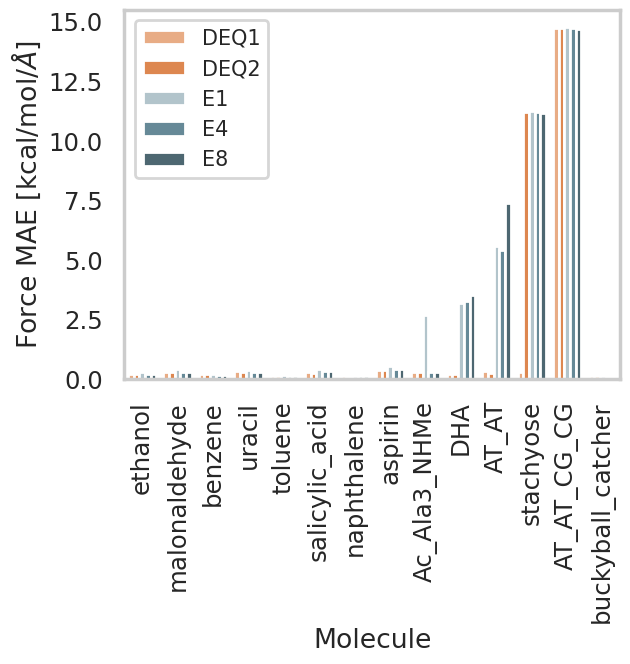

In [58]:
# plot accuracy
# grouped barchart, with target as group, and model as hue
y = error_metric
x = "config.target"
hue = "Model"
data = df_best_runs.copy()

# plot
fig, ax = plt.subplots()
sns.barplot(x=x, y=y, hue=hue, data=data, ax=ax, palette=cdict)
plt.legend()
plt.xlabel(human_labels(x))
plt.ylabel(human_labels(y))

# vertical xtick labels
plt.xticks(rotation=90)

# horizontal grid
plt.grid(axis="y")

# make a separate plot for each target

# save
# plt.savefig(f"{plotfolder}/n_steps.png")
plt.show()

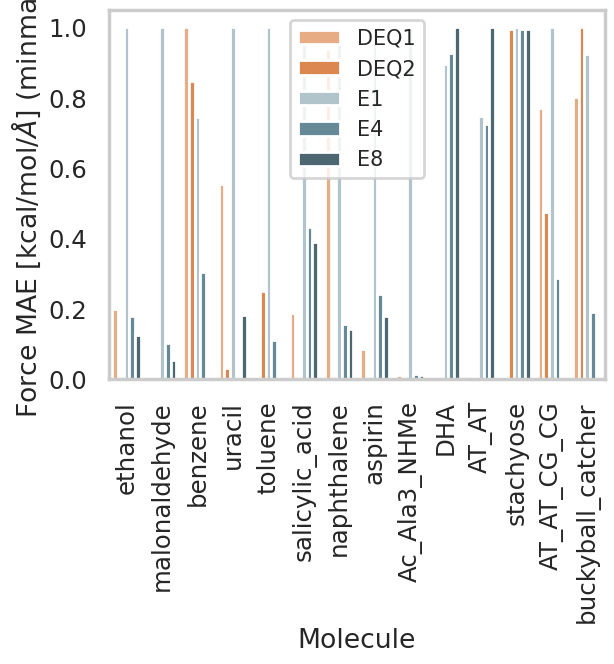

In [59]:
# plot accuracy, normalized for each target


def plot_norm_acc(
    _df, norm_scheme="minmax"
):  # norm_scheme = "zscoree4" # "mean", "minmax", "zscore", "zscoree4"

    # grouped barchart, with target as group, and model as hue
    y = error_metric
    x = "config.target"
    hue = "Model"
    data = _df.copy()

    data, ylabel = norm_targets(data, norm_scheme=norm_scheme)

    # plot
    fig, ax = plt.subplots()
    sns.barplot(x=x, y=y, hue=hue, data=data, ax=ax, palette=cdict)
    plt.legend()
    plt.xlabel(human_labels(x))
    plt.ylabel(ylabel)

    # where "sota" is True, mark the run with a green star
    # for target in data["config.target"].unique():
    #     _df = data[data["config.target"] == target]
    #     _df = _df[_df["sota"] == True]
    #     for index in _df.index:
    #         ax.plot(index, _df.loc[index, y], "o", color="green", markersize=10)

    # vertical xtick labels
    plt.xticks(rotation=90)

    # horizontal grid
    plt.grid(axis="y")

    # make a separate plot for each target

    # save
    # plt.savefig(f"{plotfolder}/n_steps.png")
    plt.show()


plot_norm_acc(df_best_runs, norm_scheme="minmax")

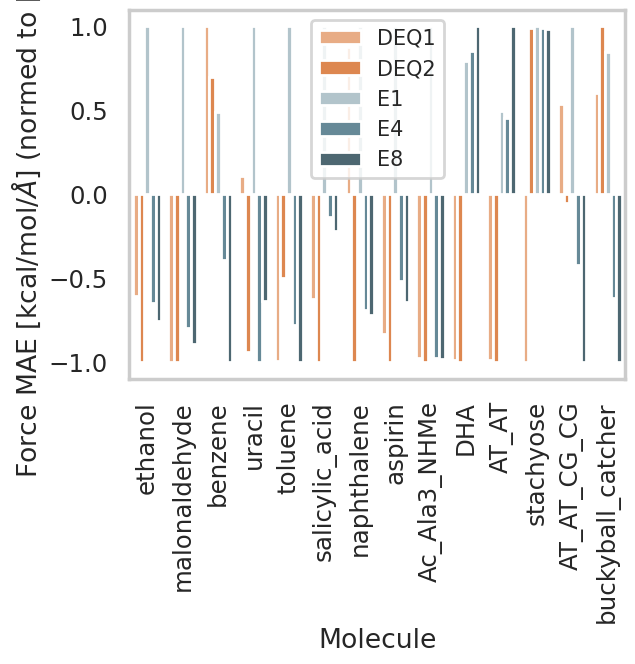

In [60]:
plot_norm_acc(df_best_runs, norm_scheme="minmax2")

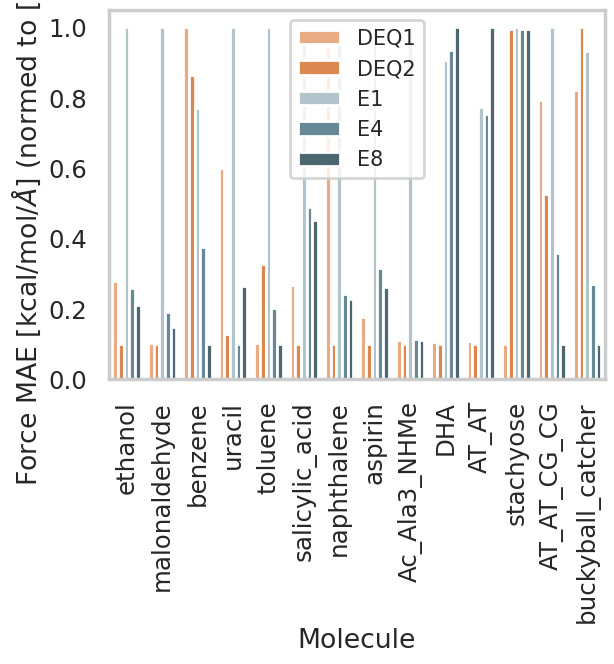

In [61]:
plot_norm_acc(df_best_runs, norm_scheme="minmax3")

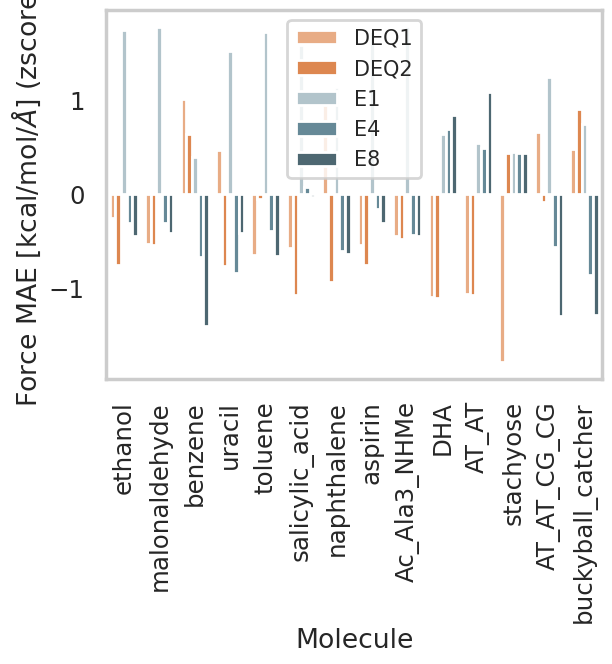

In [62]:
plot_norm_acc(df_best_runs, norm_scheme="zscore")

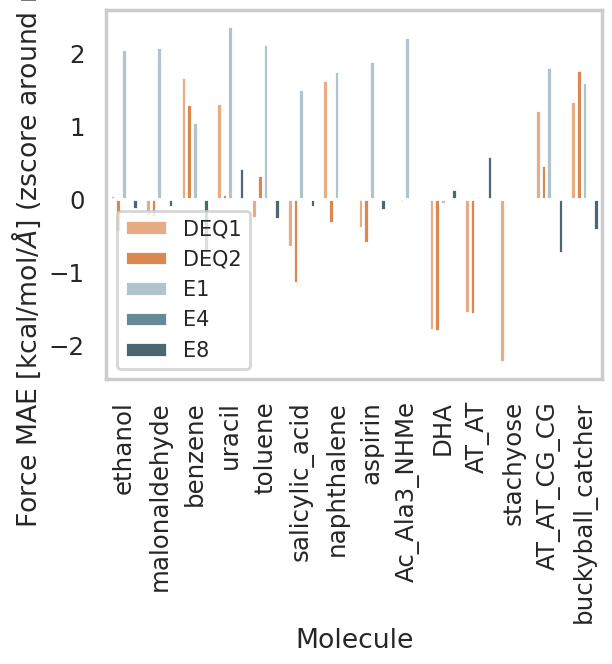

In [63]:
plot_norm_acc(df_best_runs, norm_scheme="zscoree4")

In [64]:
df_best_runs[df_best_runs["Model"] == "E4"][["run_name", "config.target"]]

,run_name,config.target
3,pEs dd ethanol,ethanol
8,pEs dd malonaldehyde,malonaldehyde
13,pEs dd benzene,benzene
18,pEs dd uracil,uracil
23,pEs dd toluene,toluene
28,pEs dd salicylicacid,salicylic_acid
33,pEs dd naphthalene,naphthalene
38,pEs dd,aspirin
43,pEs dd md22 AcAla3NHMe,Ac_Ala3_NHMe
48,pEs dd md22 DHA,DHA


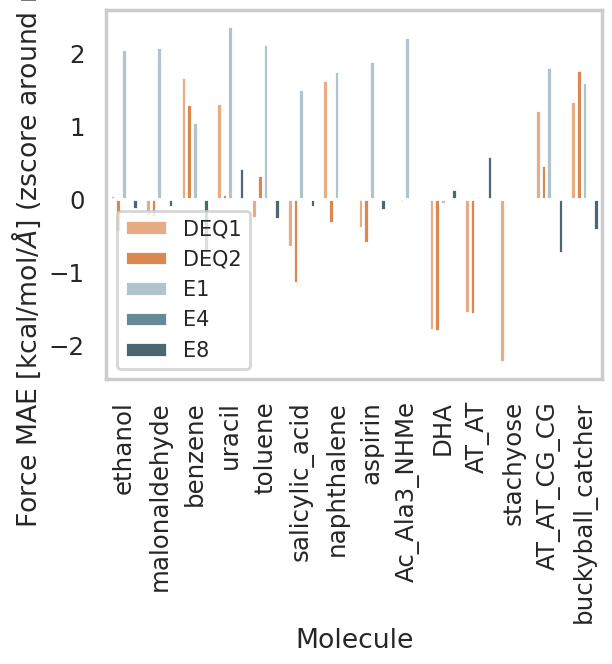

In [65]:
plot_norm_acc(df_best_runs, norm_scheme="zscoree4")

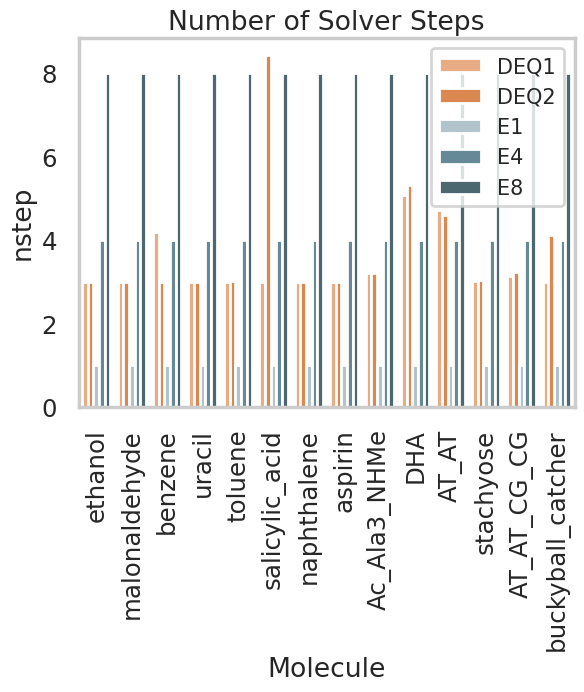

In [66]:
# plot n_step
# grouped barchart, with target as group, and model as hue

y = "nstep"
x = "config.target"
hue = "Model"
data = df_best_runs.copy()

# plot
fig, ax = plt.subplots()
sns.barplot(x=x, y=y, hue=hue, data=data, ax=ax, palette=cdict)
plt.legend()
plt.xlabel(human_labels(x))
plt.ylabel(human_labels(y))
plt.title("Number of Solver Steps")

# vertical xtick labels
plt.xticks(rotation=90)

# horizontal grid
plt.grid(axis="y")

# make a separate plot for each target

# save
# plt.savefig(f"{plotfolder}/n_steps.png")
plt.show()

# print names of plotted runs
# data["run_name"]

In [67]:
# salicyclic acid DEQ2

# df_best_runs[df_best_runs["Model"] == "DEQ2"][["run_name", "config.target", "NFE"]]
df_best_runs[df_best_runs["config.target"] == "salicylic_acid"][["run_name", "Model", "config.target", "NFE"]]

,run_name,Model,config.target,NFE
25,pDEQs bp salicylicacid,DEQ1,salicylic_acid,3.003003
26,pDEQs apt numlayers-2 salicylicacid,DEQ2,salicylic_acid,16.834835
27,pEs dd numlayers-1 salicylicacid,E1,salicylic_acid,1.000000
28,pEs dd salicylicacid,E4,salicylic_acid,4.000000
29,pEs dd numlayers-8 salicylicacid,E8,salicylic_acid,8.000000


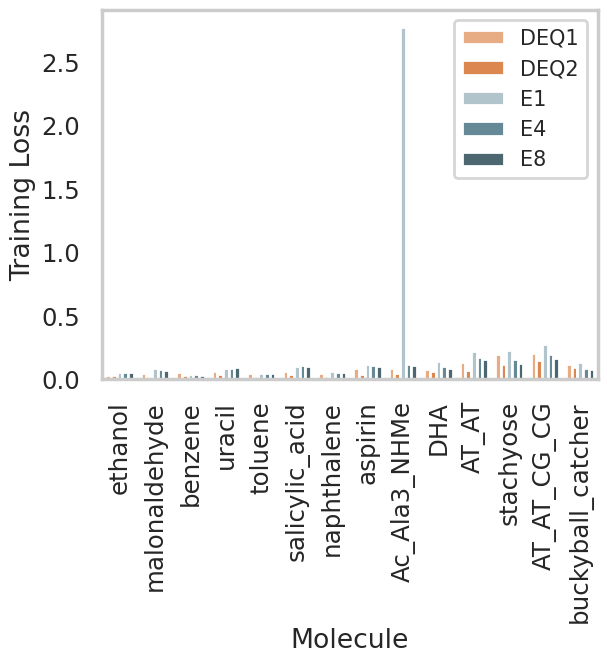

In [68]:
# plot train_loss_f

# grouped barchart, with target as group, and model as hue
if project == projectmd:
    y = "summary.train_loss_f"
elif project == projectoc:
    y = "summary.train/forces_mae"
x = "config.target"
hue = "Model"

data = df_best_runs.copy()
# DEQ is in the model name
# data = data["DEQ" in data["Model"]]
# data = data[df["Model"].str.startswith('DEQ')]

# plot
fig, ax = plt.subplots()
sns.barplot(x=x, y=y, hue=hue, data=data, ax=ax, palette=cdict)
plt.legend()
plt.xlabel(human_labels(x))
plt.ylabel(human_labels(y))

# vertical xtick labels
plt.xticks(rotation=90)

# horizontal grid
plt.grid(axis="y")

# make a separate plot for each target

# save
# plt.savefig(f"{plotfolder}/train_loss_f.png")
plt.show()

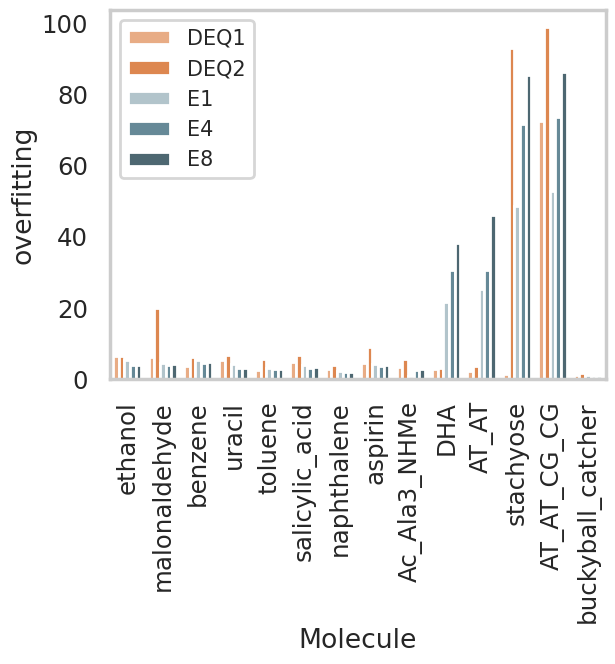

In [69]:
# overfitting = test_loss / train_loss
if project == projectmd:
    df_best_runs["overfitting"] = (
        df_best_runs["summary.test_f_mae"] / df_best_runs["summary.train_loss_f"]
    )
elif project == projectoc:
    df_best_runs["overfitting"] = (
        df_best_runs["summary.val/forces_mae"]
        / df_best_runs["summary.train/forces_mae"]
    )

y = "overfitting"
x = "config.target"
hue = "Model"

data = df_best_runs.copy()
# DEQ is in the model name
# data = data["DEQ" in data["Model"]]
# data = data[df["Model"].str.startswith('DEQ')]

# plot
fig, ax = plt.subplots()
sns.barplot(x=x, y=y, hue=hue, data=data, ax=ax, palette=cdict)
plt.legend()
plt.xlabel(human_labels(x))
plt.ylabel(human_labels(y))

# vertical xtick labels
plt.xticks(rotation=90)

# horizontal grid
plt.grid(axis="y")

# make a separate plot for each target

# save
# plt.savefig(f"{plotfolder}/train_loss_f.png")
plt.show()

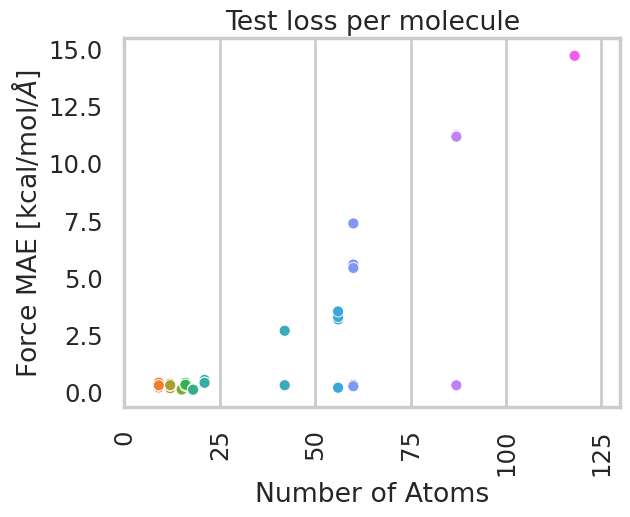

In [70]:
# plot test loss per molecule

if project == projectmd:
    fig, ax = plt.subplots()
    # sns.barplot(x=x, y=y, hue=hue, data=data, ax=ax)
    # scatterplot
    x = "num_atoms"
    # y = "summary.test_loss_f" # TODO: no longer logged?
    y = "summary.test_f_mae"  # TODO: no longer logged?
    hue = "config.target"
    sns.scatterplot(x=x, y=y, hue=hue, data=data, ax=ax)
    plt.legend()
    plt.xlabel(human_labels(x))
    plt.ylabel(human_labels(y))
    plt.title("Test loss per molecule")

    # vertical xtick labels
    plt.xticks(rotation=90)

    ax.set_xlim(0, 130)

    ax.get_legend().remove()

    # horizontal grid
    plt.grid(axis="y")

    # make a separate plot for each target

    # save
    # plt.savefig(f"{plotfolder}/train_loss_f.png")
    plt.show()

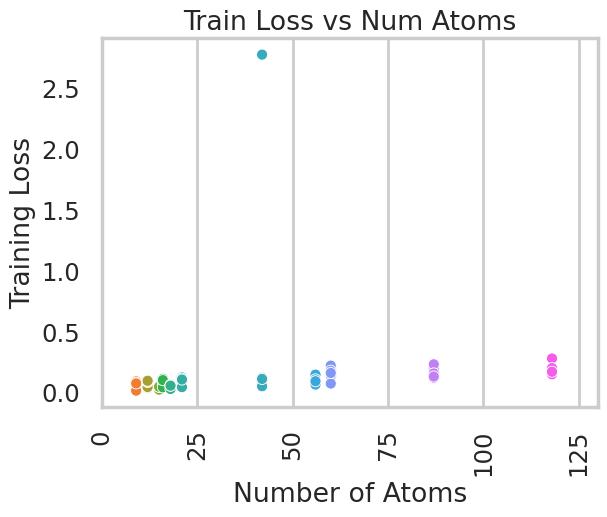

In [71]:
# plot train loss per molecule

if project == projectmd:
    fig, ax = plt.subplots()
    # sns.barplot(x=x, y=y, hue=hue, data=data, ax=ax)
    # scatterplot
    x = "num_atoms"
    y = "summary.train_loss_f"
    hue = "config.target"
    sns.scatterplot(x=x, y=y, hue=hue, data=data, ax=ax)
    plt.legend()
    plt.xlabel(human_labels(x))
    plt.ylabel(human_labels(y))
    plt.title("Train Loss vs Num Atoms")

    # vertical xtick labels
    plt.xticks(rotation=90)

    # legend off
    ax.set_xlim(0, 130)

    ax.get_legend().remove()

    # horizontal grid
    plt.grid(axis="y")

    # make a separate plot for each target

    # save
    # plt.savefig(f"{plotfolder}/train_loss_f.png")
    plt.show()

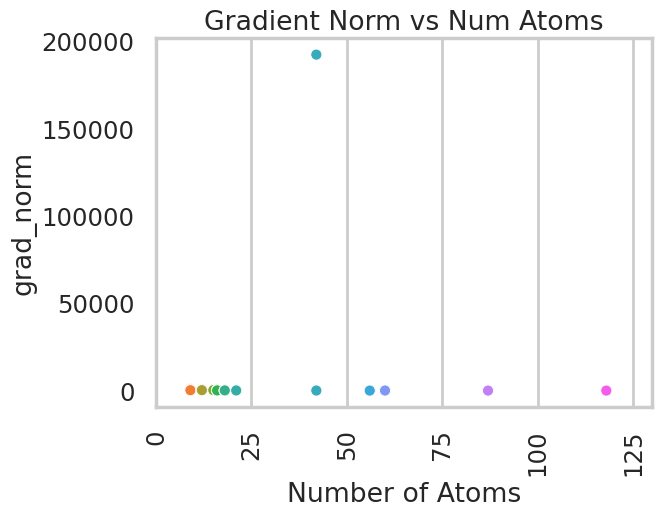

In [72]:
# plot gradient norm per molecule

fig, ax = plt.subplots()
# sns.barplot(x=x, y=y, hue=hue, data=data, ax=ax)
# scatterplot
x = "num_atoms"
y = "summary.grad_norm"
hue = "config.target"
sns.scatterplot(x=x, y=y, hue=hue, data=data, ax=ax)
plt.legend()
plt.xlabel(human_labels(x))
plt.ylabel(human_labels(y))
plt.title("Gradient Norm vs Num Atoms")

# vertical xtick labels
plt.xticks(rotation=90)

ax.set_xlim(0, 130)

ax.get_legend().remove()

# horizontal grid
plt.grid(axis="y")

# make a separate plot for each target

# save
# plt.savefig(f"{plotfolder}/train_loss_f.png")
plt.show()

### nstates

In [73]:
data["config.deq_kwargs.n_states"]

0     3.0
1     1.0
2     0.0
3     0.0
4     0.0
     ... 
65    1.0
66    3.0
67    0.0
68    0.0
69    0.0
Name: config.deq_kwargs.n_states, Length: 70, dtype: float64

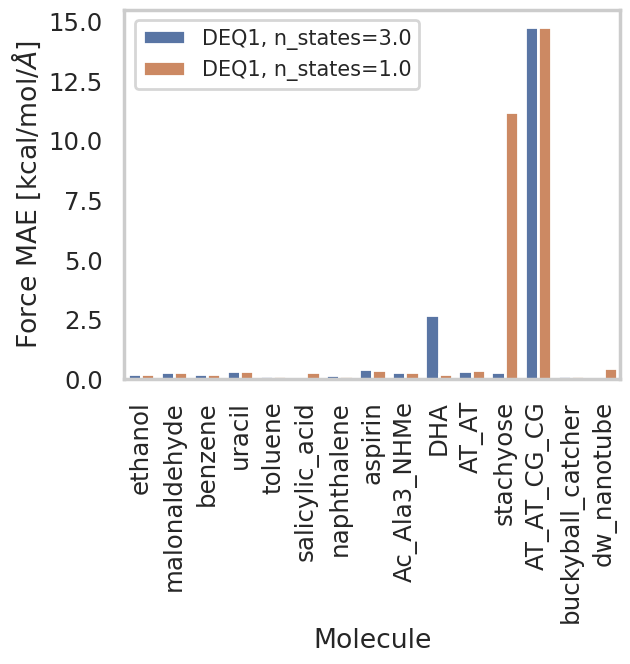

In [74]:
# compare n_states=3 to no fpc

df_nstates = []

for target in df["config.target"].unique():
    criteriatarget = {"config.target": target}

    # best DEQ
    criteria_deq = {
        "config.model_is_deq": True,
        "config.model.num_layers": 1,
        "config.deq_kwargs.n_states": 3,
        "config.deq_kwargs.f_tol": 1e-2,
        # "config.model.enc_ln": False # model.enc_ln=True
        "config.model.attn_alpha_channels": 16,
    }
    anti_criteria = {"config.dname": "ccsd"}
    criteria_deq.update(criteriatarget)
    df_nstates = add_best_run(
        df_in=df,
        df_out=df_nstates,
        metric=error_metric,
        criteria=criteria_deq,
        anti_criteria=anti_criteria,
    )

    criteria_deq["config.deq_kwargs.n_states"] = 1.0
    criteria_deq.update(criteriatarget)
    df_nstates = add_best_run(
        df_in=df,
        df_out=df_nstates,
        metric=error_metric,
        criteria=criteria_deq,
        anti_criteria=anti_criteria,
    )

df_nstates = pd.concat(df_nstates)

# add n_states to "model" column
df_nstates["Model"] = df_nstates["Model"] + df_nstates[
    "config.deq_kwargs.n_states"
].apply(lambda x: f", n_states={x}" if x is not None else "")

# grouped barchart, with target as group, and model as hue
y = "summary.test_f_mae"
x = "config.target"
hue = "Model"
data = df_nstates.copy()

# plot
fig, ax = plt.subplots()
sns.barplot(x=x, y=y, hue=hue, data=data, ax=ax)
plt.legend()
plt.xlabel(human_labels(x))
plt.ylabel(human_labels(y))

# vertical xtick labels
plt.xticks(rotation=90)

# horizontal grid
plt.grid(axis="y")

# make a separate plot for each target

# save
# plt.savefig(f"{plotfolder}/.png")
plt.show()

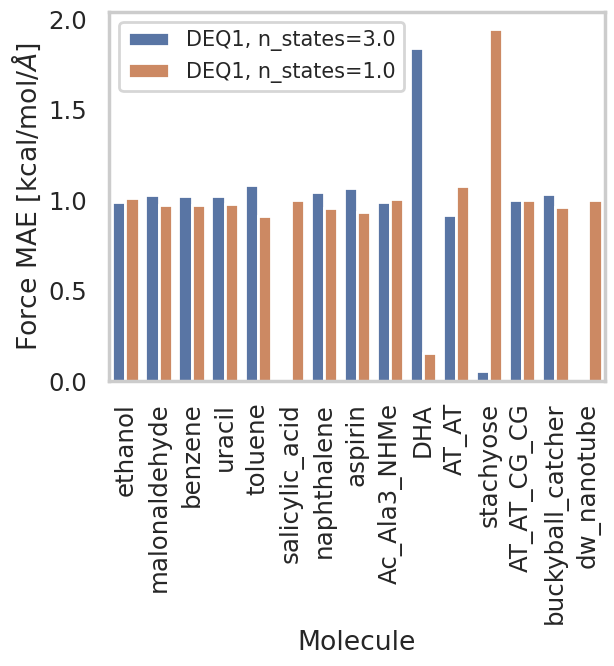

In [75]:
# compare n_states=3 to no fpc

# norm data[y] for each target
# data[y] = data.groupby(x)[y].transform(lambda x: (x - x.min()) / (x.max() - x.min()))
data[y] = data.groupby(x)[y].transform(lambda x: x / x.mean())

# plot
fig, ax = plt.subplots()
sns.barplot(x=x, y=y, hue=hue, data=data, ax=ax)
plt.legend()
plt.xlabel(human_labels(x))
plt.ylabel(human_labels(y))

# vertical xtick labels
plt.xticks(rotation=90)

# horizontal grid
plt.grid(axis="y")

# make a separate plot for each target

# save
# plt.savefig(f"{plotfolder}/.png")
plt.show()